In [19]:
from huggingface_hub import hf_hub_download
from datasets import load_dataset
import datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import word2vec
import gensim
import pickle

In [14]:
df = pd.read_pickle('../data/tifu_cleaned.pkl')

In [12]:
# Visualization
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)

    data_subset = np.asarray(data[max_items, :].todense())

    pca = PCA(n_components=2).fit_transform(data_subset)
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data_subset))

    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [plt.cm.hsv(i / max_label) for i in label_subset[idx]]

    f, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')

    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('t-SNE Cluster Plot')

def plot_3d_pca_tsna(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)

    data_subset = np.asarray(data[max_items, :].todense())

    pca = PCA(n_components=3).fit_transform(data_subset)
    tsne = TSNE(n_components=3).fit_transform(data_subset)

    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [plt.cm.hsv(i / max_label) for i in label_subset[idx]]

    f = plt.figure(figsize=(18, 8))
    
    # 3D PCA Plot
    ax1 = f.add_subplot(121, projection='3d')
    ax1.scatter(pca[idx, 0], pca[idx, 1], pca[idx, 2], c=label_subset)
    ax1.set_title('3D PCA Cluster Plot')
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.set_zlabel('Principal Component 3')

    # 3D t-SNE Plot
    ax2 = f.add_subplot(122, projection='3d')
    ax2.scatter(tsne[idx, 0], tsne[idx, 1], tsne[idx, 2], c=label_subset)
    ax2.set_title('3D t-SNE Cluster Plot')
    ax2.set_xlabel('t-SNE Dimension 1')
    ax2.set_ylabel('t-SNE Dimension 2')
    ax2.set_zlabel('t-SNE Dimension 3')

    plt.show()

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

def get_top_keywords(data, clusters, feature_names, n_terms):
    df = pd.DataFrame(np.asarray(data.todense())).groupby(clusters).mean()
    
    for i, r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([feature_names[t] for t in np.argsort(r)[-n_terms:]]))

In [16]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.95,
    max_features=8000,
    stop_words='english'
)


text_tfidf = tfidf.fit_transform(df['documents'])
text_tfidf_title = tfidf.fit_transform(df['title'])

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


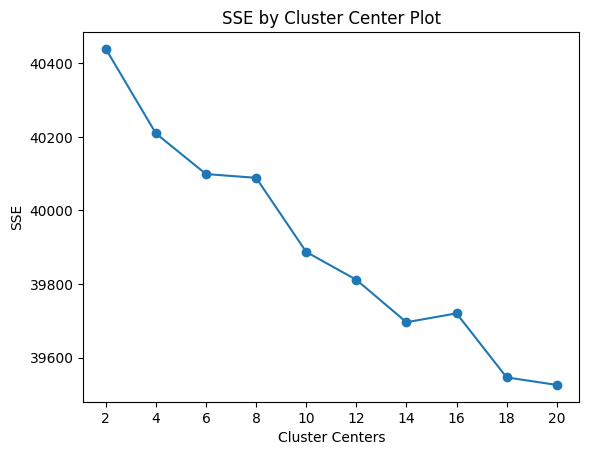

In [18]:
# Find optimal clusters
find_optimal_clusters(text_tfidf, 20)

In [21]:
# Clustering using MiniBatchKMeans
optimal_clusters = 10  # Adjust based on your findings
kmeans_clusters = KMeans(n_clusters=optimal_clusters, random_state=20).fit_predict(text_tfidf_title)
agglomerative_clusters = AgglomerativeClustering(n_clusters=optimal_clusters).fit_predict(text_tfidf_title.toarray())



Cluster 0
outside,home,house,run,high,gym,class,nsfw,wrong,school,party,bathroom,work,date,going

Cluster 1
hitting,date,having,hot,getting,calling,impress,liked,cute,little,trying,telling,like,asking,girl

Cluster 2
having,ex,sending,asking,giving,trusting,house,girlfriend,nsfw,letting,getting,trying,telling,best,friend

Cluster 3
car,use,kill,work,girlfriend,fix,good,nsfw,funny,nice,clean,save,help,make,trying

Cluster 4
phone,forgetting,wrong,thinking,playing,accidentally,girlfriend,using,car,work,eating,taking,having,nsfw,getting

Cluster 5
wife,teacher,friends,like,girlfriend,school,mom,accidentally,work,nsfw,friend,fun,think,joke,making


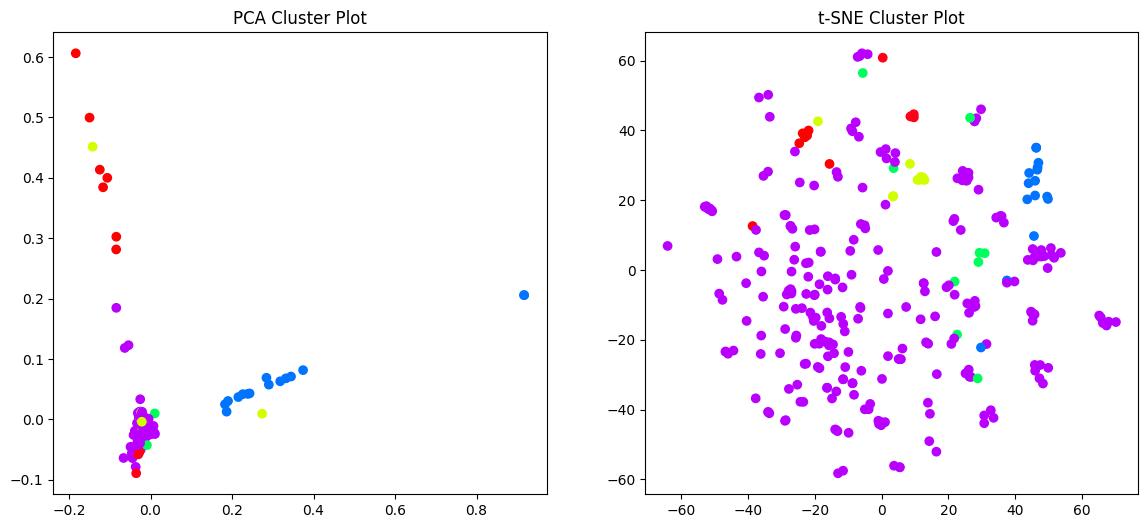

In [67]:
# Plotting PCA and t-SNE
plot_tsne_pca(text_tfidf, clusters_tfidf)

# Displaying top keywords
get_top_keywords(text_tfidf, clusters_tfidf, tfidf.get_feature_names_out(), 15)

plt.show()

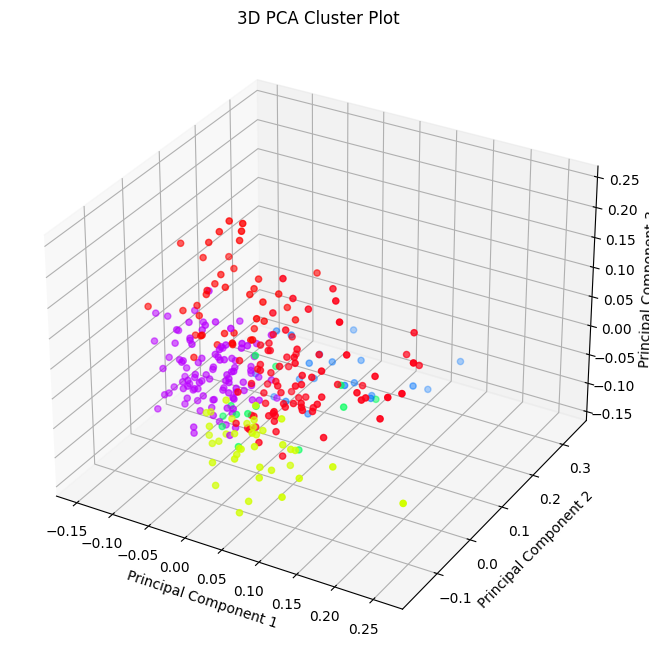

In [61]:
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D plotting tools

# Visualization for 3D PCA cluster plot
def plot_3d_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)

    data_subset = np.asarray(data[max_items, :].todense())

    pca = PCA(n_components=3).fit_transform(data_subset)

    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [plt.cm.hsv(i / max_label) for i in label_subset[idx]]

    f = plt.figure(figsize=(10, 8))
    ax = f.add_subplot(111, projection='3d')

    # 3D PCA Plot
    ax.scatter(pca[idx, 0], pca[idx, 1], pca[idx, 2], c=label_subset)
    ax.set_title('3D PCA Cluster Plot')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')

    plt.show()




In [ ]:
# Call the 3D PCA plot function
plot_3d_pca(text_tfidf, clusters_tfidf)
plot_3d_pca(text_tfidf, clusters_tfidf)

In [83]:
corpus = [
          'Text of our first sentence.',
          'Text of the second sentence that appears to be longer.',
          'Sentence number three.',
          'This is the sentence number four.',
]
tokenized_sentences = [sentence.split() for sentence in corpus]
tokenized_sentences

[['Text', 'of', 'our', 'first', 'sentence.'],
 ['Text',
  'of',
  'the',
  'second',
  'sentence',
  'that',
  'appears',
  'to',
  'be',
  'longer.'],
 ['Sentence', 'number', 'three.'],
 ['This', 'is', 'the', 'sentence', 'number', 'four.']]

In [82]:
tokenized_sentences = [sentence.split() for sentence in df['documents']]
model = word2vec.Word2Vec(tokenized_sentences, min_count=1)

print(model)


Word2Vec<vocab=308267, vector_size=100, alpha=0.025>


TypeError: 'Word2Vec' object is not subscriptable

In [111]:
model1 = gensim.models.Word2Vec(df['documents'], min_count = 1,  
                              window = 5) 

In [122]:
model.wv.most_similar('worst')

[('biggest', 0.7529879212379456),
 ('greatest', 0.7499397397041321),
 ('dumbest', 0.7097257971763611),
 ('scariest', 0.6777644753456116),
 ('stupidest', 0.6772291660308838),
 ('funniest', 0.6694784164428711),
 ('best', 0.6619434952735901),
 ('saddest', 0.6494888663291931),
 ('weirdest', 0.6402807235717773),
 ('happiest', 0.6174948811531067)]

In [105]:
model1.wv.most_similar('fuck')

KeyError: "Key 'fuck' not present in vocabulary"

In [76]:
df['tokenized_text'] = df['documents'].apply(lambda x: word_tokenize(x.lower()))


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\micha/nltk_data'
    - 'c:\\Users\\micha\\AppData\\Local\\Programs\\Python\\Python311\\nltk_data'
    - 'c:\\Users\\micha\\AppData\\Local\\Programs\\Python\\Python311\\share\\nltk_data'
    - 'c:\\Users\\micha\\AppData\\Local\\Programs\\Python\\Python311\\lib\\nltk_data'
    - 'C:\\Users\\micha\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************
